# Age, Ethnicity 

http://causality.cs.ucla.edu/blog/index.php/2020/07/06/race-covid-mortality-and-simpsons-paradox-by-dana-mackenzie/

https://unherd.com/2020/05/what-the-headline-covid-figures-dont-tell-you/

In [1]:
import sys
sys.path.insert(0, '../src/data')
import bame_datastore
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Found local clean copy of Local_Authority_Districts__December_2017__Boundaries_in_the_UK__WGS84_
Found local clean copy of fbook_covid_cases
Found local clean copy of BAME_report_cases
Found local clean copy of BAME_report_deaths
Found local clean copy of bame_excess_deaths
Found local clean copy of ons_deaths
Found local clean copy of excess_deaths_data_grp
Found local clean copy of excess_deaths_data_loc
Found local clean copy of ethnicity_2011
Found local clean copy of furlough_data
Found local clean copy of key_workers
Found local clean copy of deprivation_data
Found local clean copy of population_est_data


# Ethnicity Data
2011 census data https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/national-and-regional-populations/population-of-england-and-wales/latest#by-ethnicity

Make it compatible with Morbidity data

Maybe need to use more [up to date](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationcharacteristicsresearchtables) ethnicitiy data 


In [2]:
group_eth_dict = {'Bangladeshi': "Bangladeshis/Pakistani",
                 'Chinese': "Chinese",
                 'Indian': "Indian",
                 'Pakistani': "Bangladeshis/Pakistani",
                 'Asian other': "Other Ethnic Group",
                 'Black': "Black",
                 'Mixed':"Mixed/Multiple Ethnic Groups",
                 'White':"White",
                 'Other':"Other Ethnic Group"}

url = "https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/national-and-regional-populations/population-of-england-and-wales/latest/downloads/by-ethnicity.csv"
eth_df_raw = pd.read_csv(url, thousands=',')

eth_df = eth_df_raw.copy()
eth_df["eth_grouped"] = eth_df["Ethnicity"].map(group_eth_dict)
eth_df = eth_df.dropna().groupby("eth_grouped").sum()

total_check = eth_df.Number.sum() == eth_df_raw.loc[eth_df_raw.Ethnicity=="All"].Number #check sum up
pct_check = eth_df_raw.loc[eth_df_raw.Ethnicity=="All"]["%"]==100

eth_df.columns = ["count_people", "pct_people"]

print(total_check[0] and pct_check[0]) # checking totals work out
eth_df#.plot.pie(subplots=True)

True


,count_people,pct_people
eth_grouped,,
Bangladeshis/Pakistani,1571712,2.8
Black,1864890,3.3
Chinese,393141,0.7
Indian,1412958,2.5
Mixed/Multiple Ethnic Groups,1224400,2.2
Other Ethnic Group,1399416,2.5
White,48209395,86.0


# Covid Deaths by Ethnicity

Using COVID deaths by ethnicity and age band https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/countsandratiosofcoronavirusrelateddeathsbyethnicgroupenglandandwales

In [3]:
# COVID Deaths by Ethnicities
url = "https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fcountsandratiosofcoronavirusrelateddeathsbyethnicgroupenglandandwales%2f2march2020to10april2020/reft1countsratiocovidsexageeth06052020185223.xlsx"
r = requests.get(url)
fpath = f"../data/external/deaths_ethnicities.xlsx"
with open(fpath, 'wb') as outfile:
    outfile.write(r.content)
df_raw = pd.read_excel(fpath, sheet_name="Table 1", skiprows=2, usecols=[0,1,2,3], nrows= 28)
df = df_raw.set_index(["Ethnicity", "Ageband"]).groupby(by = ["Ethnicity", "Ageband"]).sum()


# # To Group BAME - uncomment and run to group
# df = df.reset_index()
# df['Ethnicity'] = df['Ethnicity'].apply(lambda x: x if x == "White" else "BAME")
# df = df.groupby(["Ethnicity", "Ageband"]).sum()
df

Counts of Coronavirus-related deaths
Ethnicity                    Ageband                                      
Bangladeshis/Pakistani       0-64                                      100
                             65+                                       286
Black                        0-64                                      185
                             65+                                       581
Chinese                      0-64                                       10
                             65+                                        49
Indian                       0-64                                       82
                             65+                                       401
Mixed/Multiple Ethnic Groups 0-64                                       18
                             65+                                        76
Other Ethnic Group           0-64                                       65
                             65+                                       226
White                        0-64                                     1036
                             65+                                      9690

In [4]:
df

Counts of Coronavirus-related deaths
Ethnicity                    Ageband                                      
Bangladeshis/Pakistani       0-64                                      100
                             65+                                       286
Black                        0-64                                      185
                             65+                                       581
Chinese                      0-64                                       10
                             65+                                        49
Indian                       0-64                                       82
                             65+                                       401
Mixed/Multiple Ethnic Groups 0-64                                       18
                             65+                                        76
Other Ethnic Group           0-64                                       65
                             65+                                       226
White                        0-64                                     1036
                             65+                                      9690

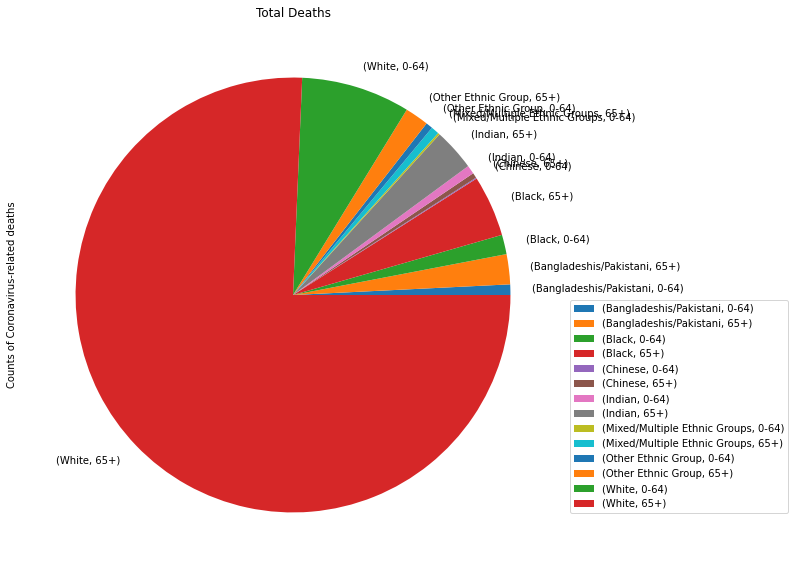

In [5]:
#add counts to the pie chart
labels = df.index
df.plot(kind="pie", subplots=True, figsize=(10,10))
plt.title('Total Deaths', color='black')
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))

plt.show()

In [6]:
# Calculating as percentage of total deaths
df_all_ages = df.groupby("Ethnicity").sum()
total_deaths = df_all_ages.sum()[0] # all covid deaths 
df_all_ages["pct_deaths"] = (df_all_ages["Counts of Coronavirus-related deaths"]/total_deaths)*100
df_all_ages.columns = ["count_deaths", "pct_deaths"]
df_all_ages

,count_deaths,pct_deaths
Ethnicity,,
Bangladeshis/Pakistani,386,3.014447
Black,766,5.982038
Chinese,59,0.460758
Indian,483,3.771964
Mixed/Multiple Ethnic Groups,94,0.734088
Other Ethnic Group,291,2.272550
White,10726,83.764155


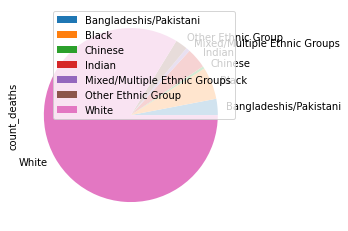

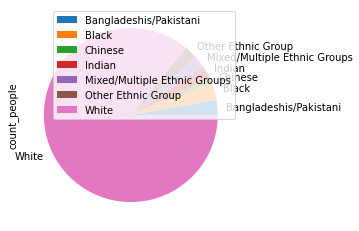

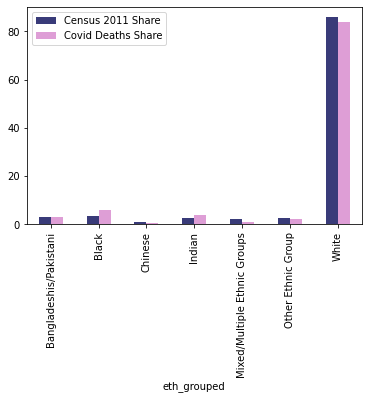

In [7]:
# Stage 1 plot percentage deaths against perventage population
plot_df = eth_df.join(df_all_ages) 
plot_df.drop(columns = ["count_people", "pct_people", "pct_deaths"]).plot(kind='pie', subplots=True)
plot_df.drop(columns = ["count_deaths", "pct_people", "pct_deaths"]).plot(kind='pie', subplots=True)

plot_df.columns = ["count_people", "Census 2011 Share", "count_deaths", "Covid Deaths Share"]
plot_df.drop(columns = ["count_people", "count_deaths",]).plot(kind='bar', colormap='tab20b')

# Simpsons Stuff

In [8]:
#tidy up age data
df_age_raw = df.groupby(by = ["Ethnicity", "Ageband"]).sum().reset_index()
df_age_raw = df_age_raw.pivot(index = "Ethnicity", columns="Ageband")
df_age_raw.columns = ["count_064", "count_64+"]
df_age_raw



,count_064,count_64+
Ethnicity,,
Bangladeshis/Pakistani,100,286
Black,185,581
Chinese,10,49
Indian,82,401
Mixed/Multiple Ethnic Groups,18,76
Other Ethnic Group,65,226
White,1036,9690


In [9]:
total_deaths

12805

In [10]:
# As % of total deaths
df_age = df_age_raw.copy()
df_age["pct_064"] = (df_age["count_064"]/total_deaths)*100
df_age["pct_64+"] = (df_age["count_64+"]/total_deaths)*100
df_age = df_age[["count_064", "pct_064", "count_64+", "pct_64+"]]
df_age

,count_064,pct_064,count_64+,pct_64+
Ethnicity,,,,
Bangladeshis/Pakistani,100,0.780945,286,2.233503
Black,185,1.444748,581,4.537290
Chinese,10,0.078094,49,0.382663
Indian,82,0.640375,401,3.131589
Mixed/Multiple Ethnic Groups,18,0.140570,76,0.593518
Other Ethnic Group,65,0.507614,226,1.764936
White,1036,8.090590,9690,75.673565


Text(0.5, 1.0, 'Covid Deaths as a percentage of Total Covid Deaths')

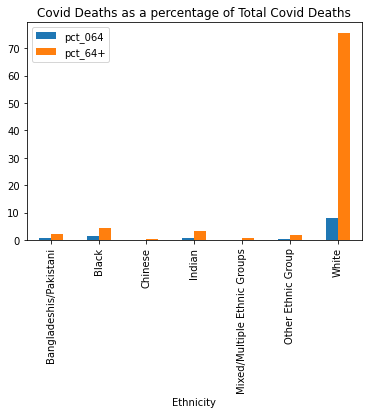

In [11]:
df_plot = df_age.drop(columns = ["count_064", "count_64+"])
df_plot.plot.bar()
plt.title("Covid Deaths as a percentage of Total Covid Deaths")

In [12]:
# As % of ageband 
under_64_tot  = df_age_raw.count_064.sum()
over_64_tot  = df_age_raw["count_64+"].sum()
df_age_alt = df_age_raw.copy()
df_age_alt["pct_064_ageband"] = (df_age_alt["count_064"]/under_64_tot)*100
df_age_alt["pct_64+_ageband"] = (df_age_alt["count_64+"]/over_64_tot)*100
df_age_alt = df_age_alt[["count_064", "pct_064_ageband", "count_64+", "pct_64+_ageband"]]
df_age_alt

,count_064,pct_064_ageband,count_64+,pct_64+_ageband
Ethnicity,,,,
Bangladeshis/Pakistani,100,6.684492,286,2.528959
Black,185,12.366310,581,5.137501
Chinese,10,0.668449,49,0.433283
Indian,82,5.481283,401,3.545848
Mixed/Multiple Ethnic Groups,18,1.203209,76,0.672031
Other Ethnic Group,65,4.344920,226,1.998408
White,1036,69.251337,9690,85.683969


In [13]:
(1-(under_64_tot/total_deaths))*100

88.31706364701289

Text(0.5, 1.0, 'Covid Deaths as a percentage of Ageband Covid Deaths')

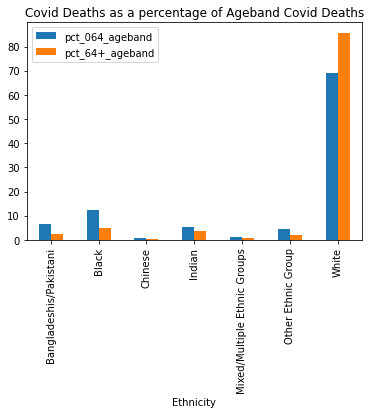

In [14]:
df_plot = df_age_alt.drop(columns = ["count_064", "count_64+"])
df_plot.plot.bar()
plt.title("Covid Deaths as a percentage of Ageband Covid Deaths")

In [15]:
# % of ethnicity 
df_age_eth = df_age_raw.copy()

df_age_eth["eth_total"] = df_all_ages.count_deaths
df_age_eth
df_age_eth["pct_064_ethnicity"] = (df_age_eth["count_064"]/df_age_eth["eth_total"])*100
df_age_eth["pct_64+_ethnicity"] = (df_age_eth["count_64+"]/df_age_eth["eth_total"])*100
df_age_eth

,count_064,count_64+,eth_total,pct_064_ethnicity,pct_64+_ethnicity
Ethnicity,,,,,
Bangladeshis/Pakistani,100,286,386,25.906736,74.093264
Black,185,581,766,24.151436,75.848564
Chinese,10,49,59,16.949153,83.050847
Indian,82,401,483,16.977226,83.022774
Mixed/Multiple Ethnic Groups,18,76,94,19.148936,80.851064
Other Ethnic Group,65,226,291,22.336770,77.663230
White,1036,9690,10726,9.658773,90.341227


Text(0.5, 1.0, 'Covid Deaths as a percentage of Ethnicity Covid Deaths')

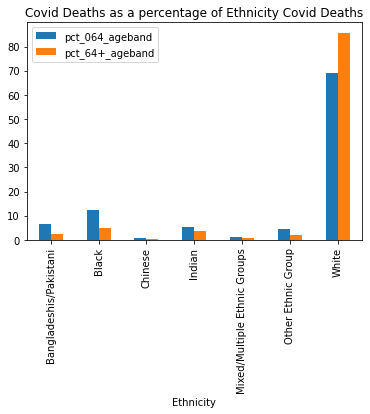

In [16]:
df_plot = df_age_alt.drop(columns = ["count_064", "count_64+"])
df_plot.plot.bar()
plt.title("Covid Deaths as a percentage of Ethnicity Covid Deaths")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1258bb710>],
      dtype=object)

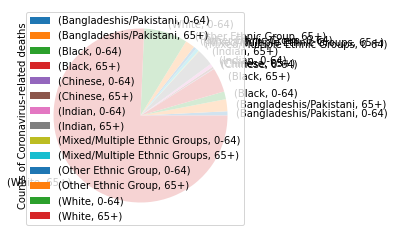

In [17]:
df.plot.pie(subplots=True)

# Clear Representation

array([<matplotlib.axes._subplots.AxesSubplot object at 0x125fbf1d0>],
      dtype=object)

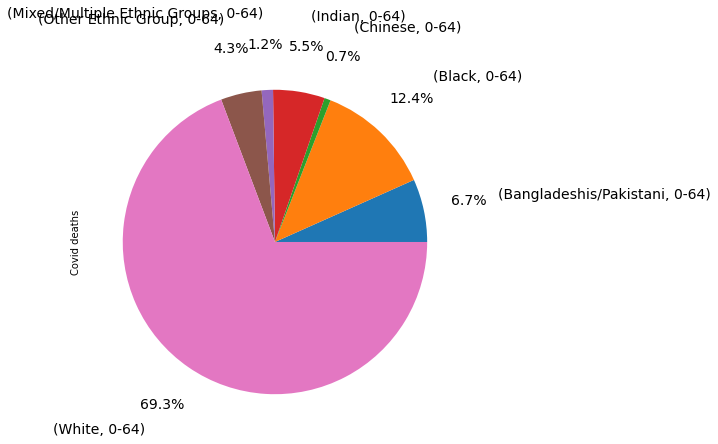

In [33]:
plot_df = df.query("Ageband in ['0-64']")
plot_df.columns = ["Covid deaths"]
plot_df.plot.pie(subplots=True, autopct='%.001f%%', legend = False,
                 pctdistance=1.3, labeldistance=1.5, figsize=(7,7), textprops={'fontsize': 14})


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1257ca990>],
      dtype=object)

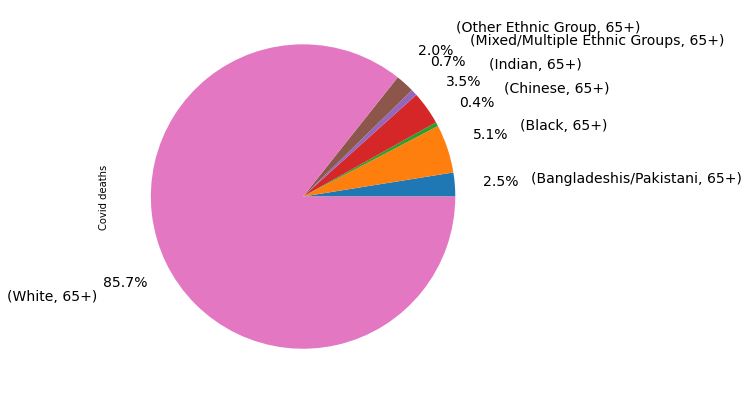

In [30]:
plot_df = df.query("Ageband not in ['0-64']")
plot_df.columns = ["Covid deaths"]
plot_df.plot.pie(subplots=True, autopct='%.001f%%', pctdistance=1.3, labeldistance=1.5,
                 legend = False, figsize=(7,7), textprops={'fontsize': 14})




array([<matplotlib.axes._subplots.AxesSubplot object at 0x125e3e110>],
      dtype=object)

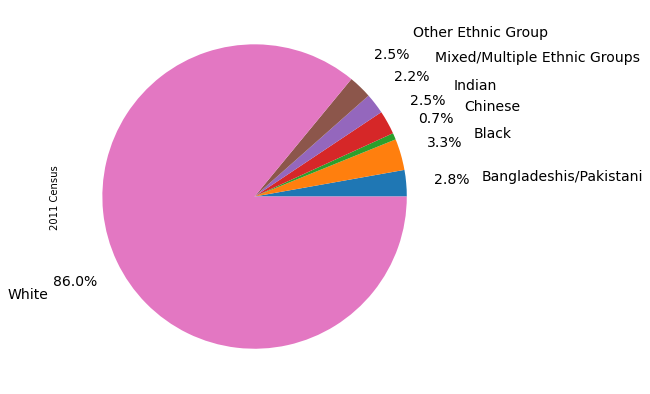

In [28]:
plot_df = eth_df.copy()
plot_df.columns = ["2011 Census", "2011 Census Ethnicity pct"]
plot_df

plot_df["2011 Census"].plot.pie(subplots=True, autopct='%.001f%%',
                                pctdistance=1.3, labeldistance=1.5, figsize=(7,7), textprops={'fontsize': 14})

